In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import date, timedelta
from itertools import product
from typing import Callable, Tuple

from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller

import utils


foot_traffic = pd.read_csv('data/foot_traffic.csv')
foot_traffic.columns = ['traffic']

inital_date = date(2000, 1, 1)
one_week_delta = timedelta(weeks=1)

weekly_dates = []
for i in range(len(foot_traffic)):
    weekly_dates.append((i * one_week_delta) + inital_date)
    

foot_traffic['date'] = pd.to_datetime(weekly_dates)
foot_traffic.set_index('date', inplace=True)
foot_traffic.index.freq = 'W-SAT'
foot_traffic.head()

,traffic
date,
2000-01-01,500.496714
2000-01-08,500.522366
2000-01-15,501.426876
2000-01-22,503.295990
2000-01-29,504.132695


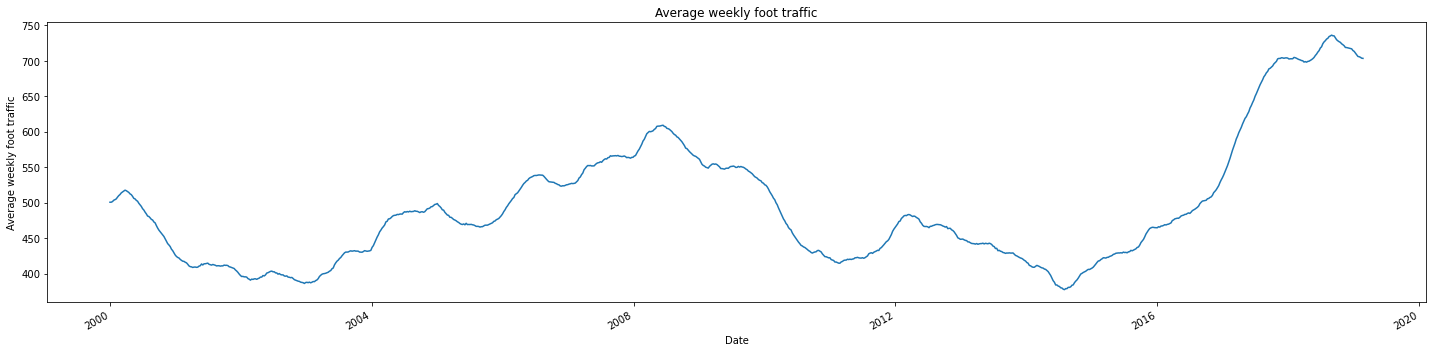

In [2]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(foot_traffic['traffic'])
ax.set_xlabel('Date')
ax.set_ylabel('Average weekly foot traffic')

fig.autofmt_xdate()
plt.title('Average weekly foot traffic')
plt.tight_layout()

plt.show();

### Find the number of differencing need to make for stationarity

In [3]:
d = 0
data_to_test_adf = foot_traffic.copy()
while (True):
    adf_test = adfuller(data_to_test_adf['traffic'], maxlag=30)
    print(adf_test)
    if adf_test[1] < 0.05:
        break
    else: 
        data_to_test_adf['traffic'] = data_to_test_adf['traffic'].diff()
        data_to_test_adf.dropna(inplace=True)   
        d = d + 1

del data_to_test_adf
print(d)

(-1.1758885999240742, 0.6838808917896192, 3, 996, {'1%': -3.4369325637409154, '5%': -2.8644462162311934, '10%': -2.568317409920808}, 2720.9865892081316)
(-5.268231347422029, 6.369317654781772e-06, 2, 996, {'1%': -3.4369325637409154, '5%': -2.8644462162311934, '10%': -2.568317409920808}, 2714.866131952428)
1


### Create test and training sets

In [4]:
test_set_size = int(0.1 * foot_traffic.shape[0]) # one week worth for forecasting

df = foot_traffic.copy()

train = df[:-test_set_size]
test = df[-test_set_size:]

print(len(train))
print(len(test))

900
100


### Create the optimize_arima function that returns the arima order and the aic sorted in descending order

In [5]:
optimal_arima_df = utils.optimize_arima(train['traffic'], i=1) # I migrated this implemenation to utils.py
optimal_arima_df.head()

/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,order,aic,sse
13,"(3, 1)",2523.887340,251358.115856
7,"(1, 3)",2524.349248,251358.543884
12,"(3, 0)",2525.375131,251361.462950
15,"(3, 3)",2525.920422,251356.223785
11,"(2, 3)",2526.262335,251358.459067


### We pick the best performing order and use the order

In [18]:
arima_order = (3, d, 0)
arima_model = ARIMA(train['traffic'], order=arima_order).fit()
res = arima_model.resid
print(arima_model.aic, arima_model.sse)

2525.3751313146677 251361.46295024076


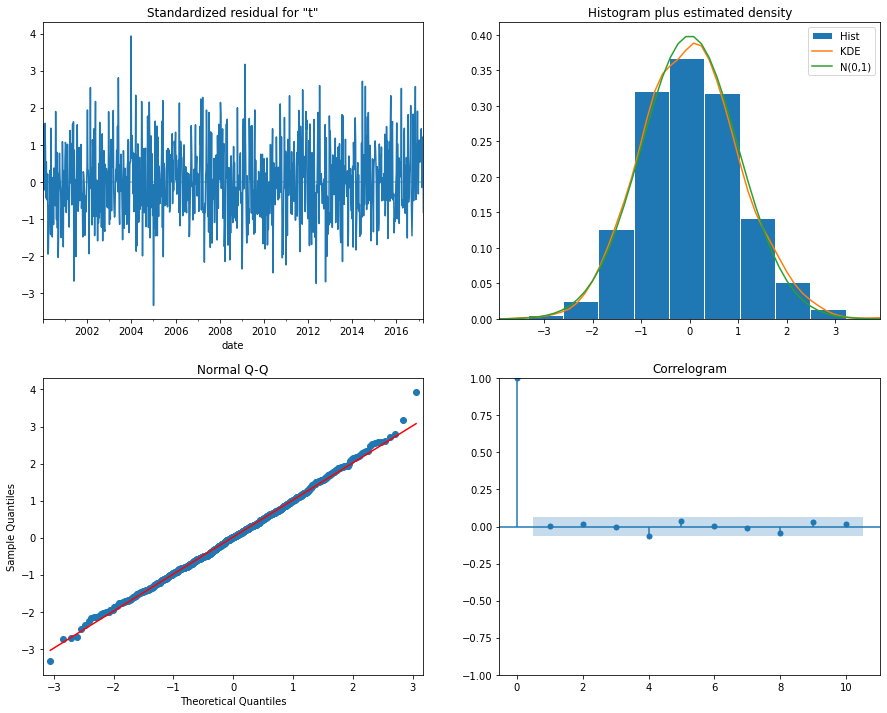

In [19]:
arima_model.plot_diagnostics(figsize=(15, 12));

In [20]:
ljungbox_test_df = acorr_ljungbox(arima_model.resid, np.arange(1, 11, 1))
auto_corr_test = np.sum(ljungbox_test_df.loc[:, 'lb_pvalue'].values < 0.05)
print('Residuals is a white noise' if auto_corr_test == 0 else 'Residuals is autocorrelated')

Residuals is a white noise


### 6.6 Forecasting sales using rolling prediction

In [21]:
def arima_predict_function(arr, arma_order, window):
    arima = ARIMA(arr, order=arma_order)
    fit = arima.fit()
    return fit.get_forecast(steps=window).predicted_mean

total_len = foot_traffic.shape[0]
train_len = train.shape[0]
window = 2

test.loc[:, 'predicted_traffic'] = utils.pd_rolling_forecast(
    foot_traffic['traffic'], total_len, train_len, window, 'ARMA', arima_order, arima_predict_function)

/var/folders/xl/w9y4tjx938vdwtkgzwxsxx8m0000gp/T/ipykernel_34584/3683611357.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'predicted_traffic'] = utils.pd_rolling_forecast(


In [22]:
test.head()

,traffic,predicted_traffic
date,,
2017-04-01,598.523173,598.150358
2017-04-08,602.122662,602.069569
2017-04-15,606.066299,606.022066
2017-04-22,610.789036,609.487038
2017-04-29,614.762421,614.558963


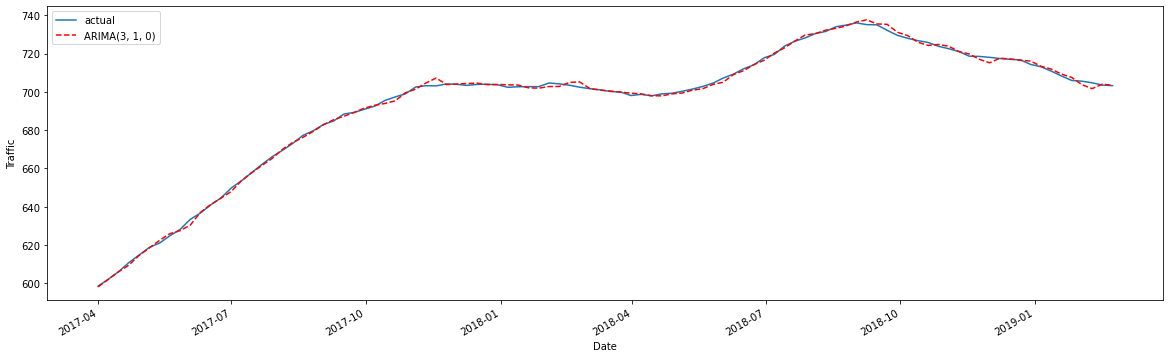

In [23]:
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(test.traffic, label='actual')
ax.plot(test.predicted_traffic, 'r--', label=f'ARIMA{arima_order}')
ax.legend(loc=2)

ax.set_xlabel('Date')
ax.set_ylabel('Traffic')

fig.autofmt_xdate()
plt.show()

In [24]:
mse_arima = mean_squared_error(test['traffic'], test['predicted_traffic'])
print(mse_arima)

1.479223479524218


In [25]:
mae_arima = mean_absolute_error(test['traffic'], test['predicted_traffic'])
print(mae_arima)

0.9039527831634007
